In [1]:
#Plot SIG and BKG Files

import csky as cy
import numpy as np
import pandas as pd
import glob
import healpy as hp
import pickle, datetime, socket
import histlite as hl
now = datetime.datetime.now
import matplotlib.pyplot as plt
import click, sys, os, time
import config as cg
import utils
flush = sys.stdout.flush

Running as User: shiqiyu on Hostname: cobalt03.icecube.wisc.edu


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import histlite as hl
import matplotlib
cy.plotting.mrichman_mpl()
colors=['blue', 'green']#, '#ffd343','purple']

In [3]:
font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [6]:
repo, ana_dir, base_dir, job_basedir = cg.repo, cg.ana_dir, cg.base_dir, cg.job_basedir

specs = cy.selections.ESTESDataSpecs.ESTES_2011_2020_pass2_0
version = 'version-p001-p00'
ana = cy.get_analysis(repo, version, specs,
    space_bg_kw = {'mc_weight':'bg_weight'}, energy_kw = {'bg_from_mc_weight': 'bg_weight'}, 
    load_sig = True)
df_orig = pd.read_hdf('/cvmfs/icecube.opensciencegrid.org/users/shiqiyu/selected_xray_fullsky_seyferts.h5')
idx = np.logical_and(df_orig['DECdeg'] < -5, df_orig['DECdeg'] > -80)
idx2 = df_orig['neutrino_expectation'] >= 1 #10 #top 3

cat = df_orig[idx&idx2].sort_values(by='neutrino_expectation', ascending=False).copy(deep=True)
src_dist = cat['DIST']
src_log_lumin = cat['logL2-10-intr']
flux=cat['F2-10-intr']
cutoff_GeV = np.inf * 1e3
weights = flux#np.zeros(len(cat))
#weights[0] = 40

Setting up Analysis for:
ESTES_2011_2020_pass2_0
Setting up ESTES_2011_2020_pass2_0...
Reading /home/shiqiyu/analysis/wg-nu-sources/ESTES_seyfert/data/version-p001-p00/MC_All_Combined.npy ...
Reading /home/shiqiyu/analysis/wg-nu-sources/ESTES_seyfert/data/version-p001-p00/IC86_2011_exp.npy ...
Reading /home/shiqiyu/analysis/wg-nu-sources/ESTES_seyfert/data/version-p001-p00/IC86_2012_exp.npy ...
Reading /home/shiqiyu/analysis/wg-nu-sources/ESTES_seyfert/data/version-p001-p00/IC86_2013_exp.npy ...
Reading /home/shiqiyu/analysis/wg-nu-sources/ESTES_seyfert/data/version-p001-p00/IC86_2014_exp.npy ...
Reading /home/shiqiyu/analysis/wg-nu-sources/ESTES_seyfert/data/version-p001-p00/IC86_2015_exp.npy ...
Reading /home/shiqiyu/analysis/wg-nu-sources/ESTES_seyfert/data/version-p001-p00/IC86_2016_exp.npy ...
Reading /home/shiqiyu/analysis/wg-nu-sources/ESTES_seyfert/data/version-p001-p00/IC86_2017_exp.npy ...
Reading /home/shiqiyu/analysis/wg-nu-sources/ESTES_seyfert/data/version-p001-p00/IC86_2

In [46]:
def plot_stacking_sig(corona_sig, PL_sig, name1, name2, nsigs=100):
    nsigs = nsigs
    tss = corona_sig['cutoff_TeV'][np.inf]['nsig'][nsigs]['ts']
    pl_tss = PL_sig['cutoff_TeV'][np.inf]['nsig'][nsigs]['ts']
    
    title = 'Signal TS: nsig = '+str(nsigs)
    fig, ax = plt.subplots(figsize=(18,16))

    PLlabels = "{} fit, nsig = {}".format(name2, nsigs)
    labels = "{} fit, nsig = {}".format(name1, nsigs)
    bins=np.linspace(0,np.max(pl_tss),50)
    plt.hist(pl_tss, bins=bins, label=PLlabels, histtype='stepfilled', linewidth=3, alpha=0.5)
    plt.hist(tss, bins=bins,histtype='step', linewidth=3, label=labels)
    #plt.plot([],[],'', color='k', label="Model fit")


    plt.axvline(np.median(pl_tss), color='gray', linestyle='dashed', linewidth=3, label='median of {} fit TS'.format(name2))
    plt.axvline(np.median(tss), color='blue', linestyle='dashed', linewidth=3, label='median of {} fit TS'.format(name1))

    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.set_title(title)
    ax.legend()

    #plt.yscale('log')
    plt.tight_layout()
    cy.plotting.saving(cy.utils.ensure_dir('./plots/stacking/signal'), 'stacking_signal_TS_'+name1+'_vs_'+name2)
   

In [44]:
model_fit_sig= np.load('./data/analyses/baseline_analysis/stacking/seyfert_southernsky_30_corona_flux_nosigsub_sig.dict', allow_pickle=True)
PL_fi_sig = np.load('./data/analyses/baseline_analysis/stacking/seyfert_southernsky_30_corona_powerlaw_weightedfit_nosigsub_sig.dict', allow_pickle=True)


-> ./plots/stacking/signal/stacking_signal_TS_model_vs_PL


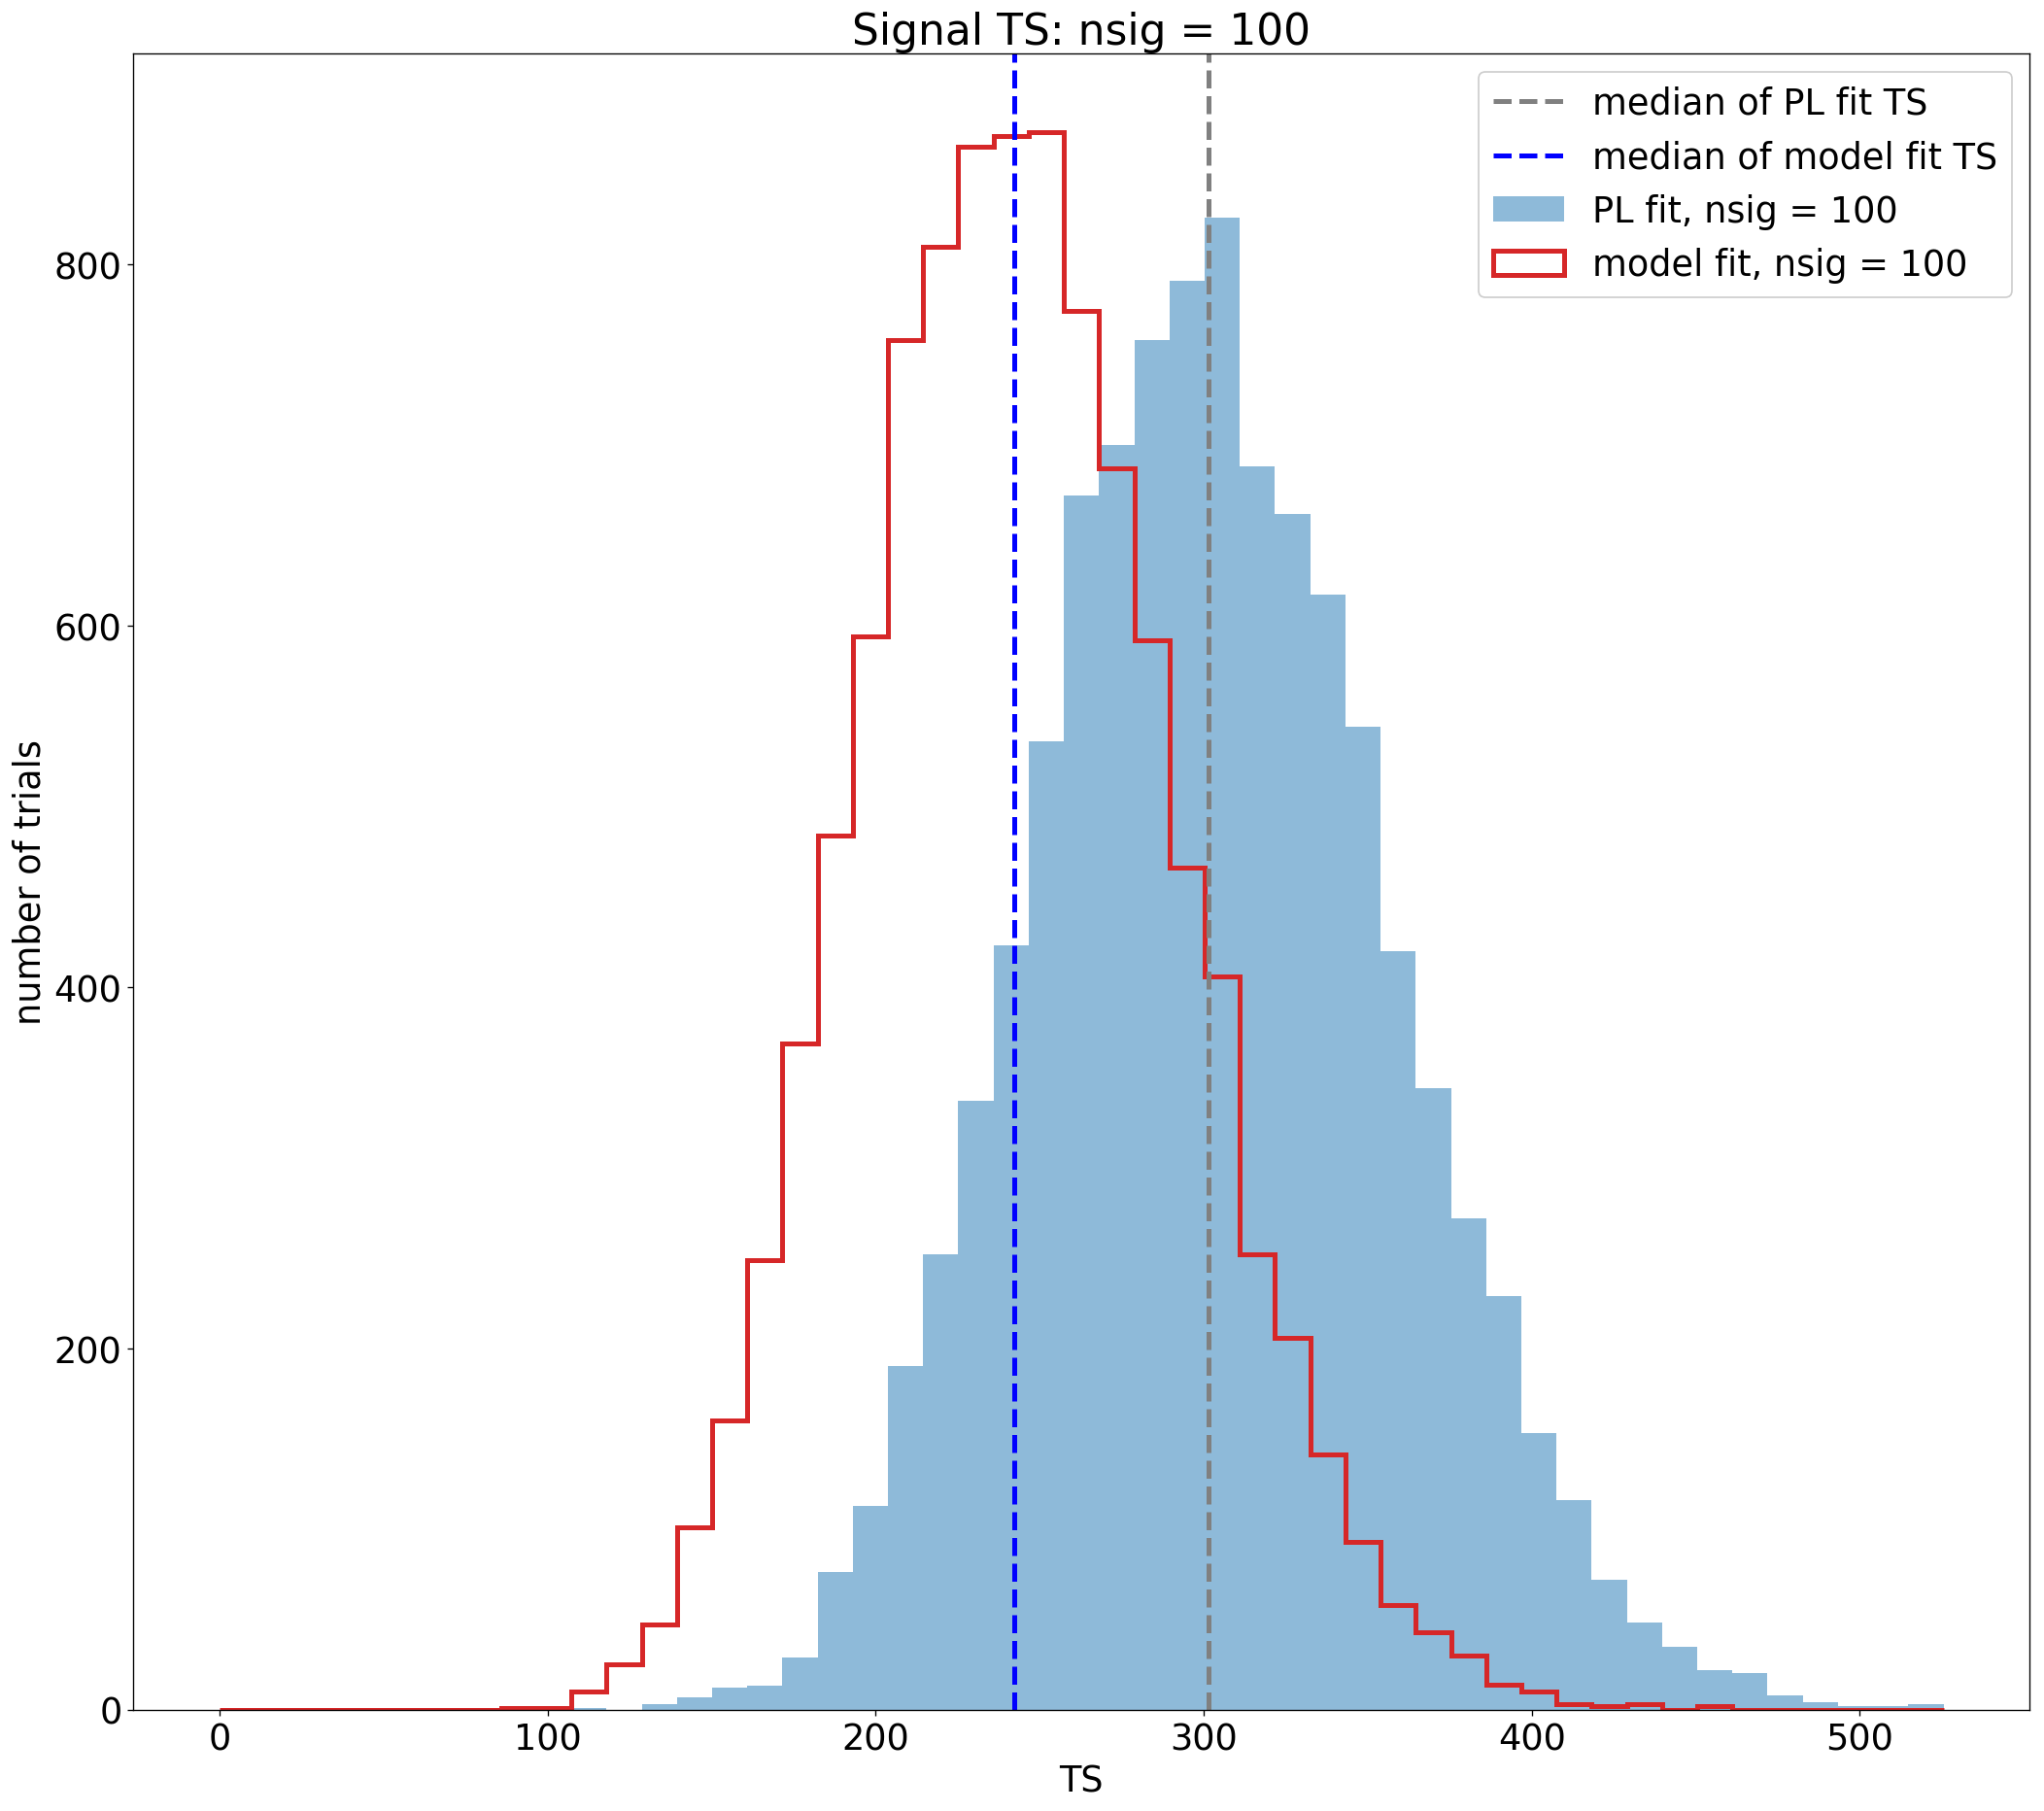

In [47]:

plt.rcParams["text.usetex"] = False

plot_stacking_sig(model_fit_sig, PL_fi_sig, 'model','PL')

In [48]:
model_fit_bg= np.load('./data/analyses/baseline_analysis/stacking/seyfert_southernsky_30_corona_flux_bg.dict', allow_pickle=True)
PL_fit_bg = np.load('./data/analyses/baseline_analysis/stacking/seyfert_southernsky_30_corona_powerlaw_weightedfit_bg.dict', allow_pickle=True)


In [74]:
def plot_stacking_bkg(corona_bg, pl_bg, name='model', pl_name = 'PL'):
    b = cy.dists.Chi2TSD(corona_bg)
    pl_b = cy.dists.Chi2TSD(pl_bg)
    
    title = 'BKG Stacking: {}'.format(name)

    fig, ax = plt.subplots(figsize=(12,8))
    bins = np.linspace(0,np.max(corona_bg.ts), 30)
    h = b.get_hist(bins=bins)
    pl_h = pl_b.get_hist(bins=bins)
    hl.plot1d(ax, h, crosses=True, c='b',
              label='{} bg trials ({})'.format(b.n_total, name))
    hl.plot1d(ax, pl_h, crosses=True, c='g',
              label='{} bg trials ({})'.format(pl_b.n_total, pl_name))
    x = h.centers[0]
    pl_x = h.centers[0]

    pl_x = pl_h.centers[0]
    norm = h.integrate().values
    pl_norm = pl_h.integrate().values

    ax.semilogy(x, norm * b.pdf(x), lw=2, ls='--',  c='b',
                label=r'$\chi^2[{:.2f}\sf{{dof}},\ \eta={:.3f}]$ ({})'.format(b.ndof, b.eta, name))
    ax.semilogy(pl_x, pl_norm * pl_b.pdf(pl_x), lw=2, ls='--', c='g',
                label=r'$\chi^2[{:.2f}\sf{{dof}},\ \eta={:.3f}]$ ({})'.format(pl_b.ndof, pl_b.eta, pl_name))
    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.set_title(title)
    ax.axvline(b.isf(0.9), c='b', ls = '--', label='sens (From Fit) ({})'.format(name))
    ax.axvline(pl_b.isf(0.9), c='g', ls = '--', label='sens (From Fit) ({})'.format(pl_name))

    ax.axvline(b.isf_nsigma(5), c='b', ls = '--', label='5$\sigma$ (From Fit) ({})'.format(name))
    ax.axvline(b.isf_nsigma(3), c='b', ls = ':', label='3$\sigma$ (From Fit) ({})'.format(name))
    ax.axvline(pl_b.isf_nsigma(5), c='g', ls = '--', label='5$\sigma$ (From Fit) ({})'.format(pl_name))
    ax.axvline(pl_b.isf_nsigma(3), c='g', ls = ':', label='3$\sigma$ (From Fit) ({})'.format(pl_name))
    
    ax.legend()
    plt.tight_layout()
    cy.plotting.saving(cy.utils.ensure_dir('./plots/stacking/bkg'), 'stacking_signal_TS_'+name+'_vs_'+pl_name)

-> ./plots/stacking/bkg/stacking_signal_TS_model_vs_PL


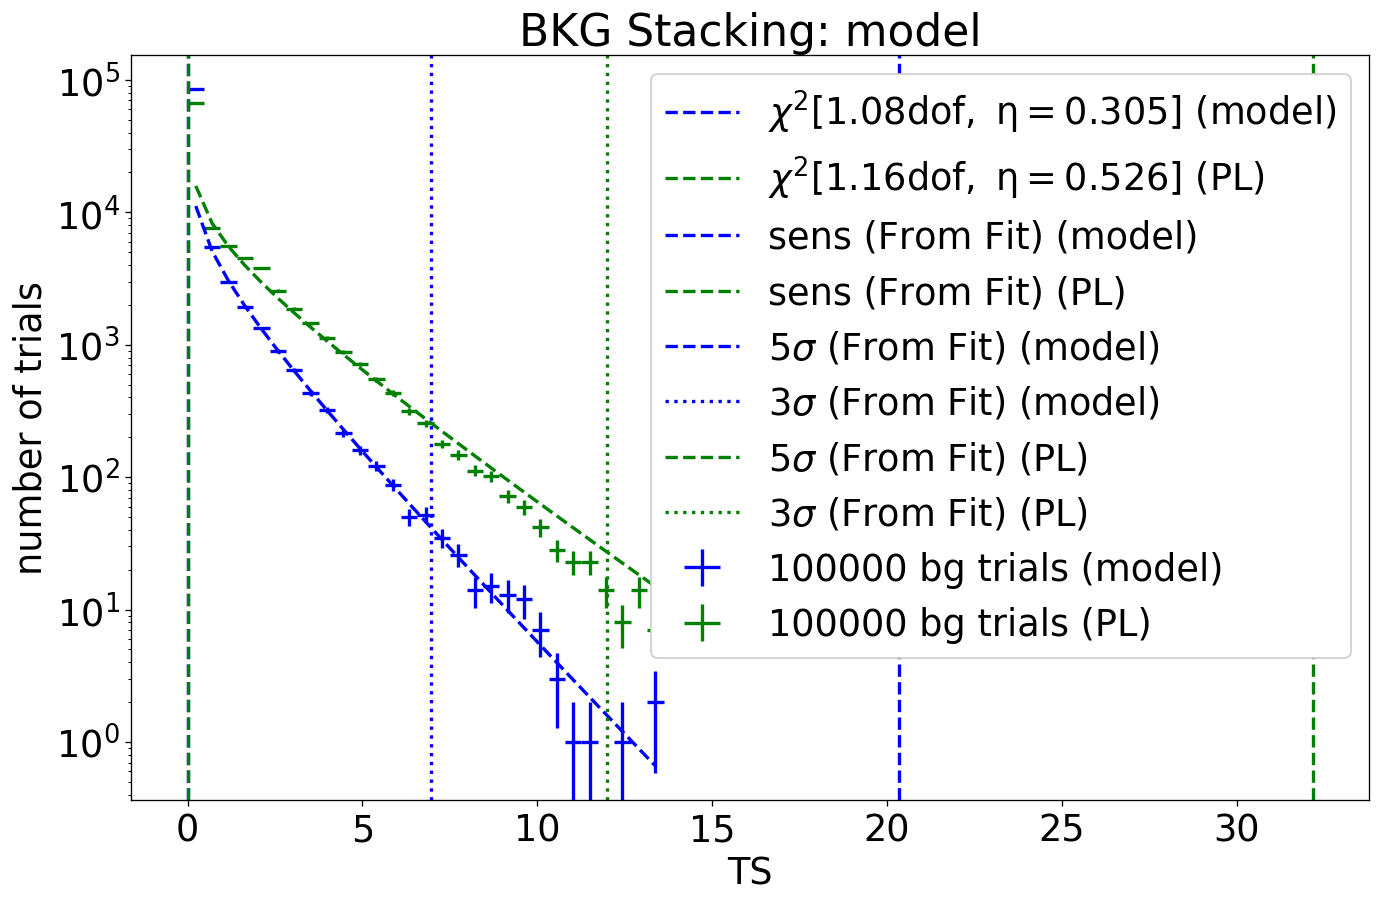

In [75]:
plot_stacking_bkg(model_fit_bg, PL_fit_bg)